# 02. Ten Armed Bandits Environment

In [5]:
using ReinforcementLearning

In [6]:
env = MultiArmBanditsEnv()

# MultiArmBanditsEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |       TerminalReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |   Observation{Int64}() |
| DefaultStateStyle |   Observation{Int64}() |

## Is Environment Terminated?

No

## State Space

`Base.OneTo(1)`

## Action Space

`Base.OneTo(10)`

## Current State

```
1
```


In [7]:
using Plots
using StatsPlots

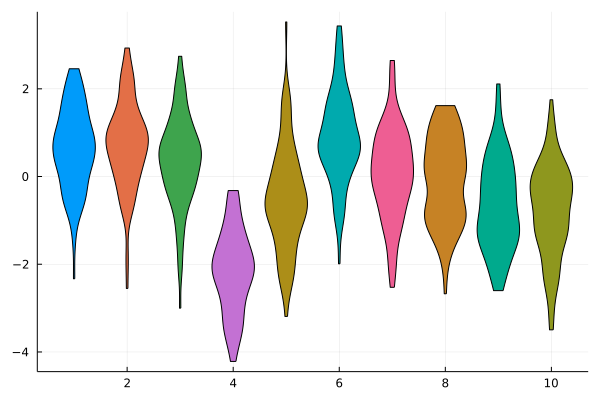

In [9]:
violin(
	[
		[
			begin 
				reset!(env)
				env(a)
				reward(env)
			end
			for _ in 1:100
		]
		for a in action_space(env)
	],
	leg=false
)

In [10]:
"""
A customized hook to record whether the action to take is the best action or not.
"""
begin
	Base.@kwdef struct CollectBestActions <: AbstractHook
		best_action::Int
		isbest::Vector{Bool} = []
	end

	function (h::CollectBestActions)(::PreActStage, agent, env, action)
		push!(h.isbest, h.best_action==action)
	end
end

In [11]:
using Flux
using Statistics

In [12]:
function bandit_testbed(
	;explorer=EpsilonGreedyExplorer(0.1),
	true_reward=0.0,
	init=0.,
	opt=InvDecay(1.0)
)
   env = MultiArmBanditsEnv(;true_reward=true_reward)
   agent = Agent(
	   policy=QBasedPolicy(
		   learner = TDLearner(
			   approximator = TabularQApproximator(
				   n_state=length(state_space(env)),
				   n_action=length(action_space(env)),
				   init=init,
				   opt = opt
			   ),
			   γ = 1.0,
			   method=:SARSA,
			   n = 0,
		   ),
		   explorer = explorer
	   ),
	   trajectory=VectorSARTTrajectory()
	)
	h1 = CollectBestActions(;best_action=findmax(env.true_values)[2])
	h2 = TotalRewardPerEpisode(;is_display_on_exit=false)
	run(agent, env, StopAfterStep(1000), ComposedHook(h1, h2))
    h1.isbest, h2.rewards
end

bandit_testbed (generic function with 1 method)

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = VectorTrajectory(; kwargs::Base.Pairs{Symbol, DataType, NTuple{4, Symbol}, NamedTuple{(:state, :action, :reward, :terminal), NTuple{4, DataType}}}) at trajectory.jl:455
└ @ ReinforcementLearningCore /home/vscode/.julia/packages/ReinforcementLearningCore/hGrFE/src/policies/agents/trajectories/trajectory.jl:455


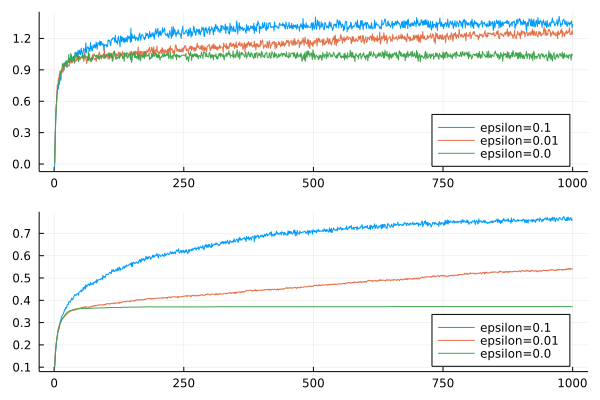

In [13]:
p = plot(layout=(2, 1))
for ϵ in [0.1, 0.01, 0.0]
	stats = [
		bandit_testbed(;explorer=EpsilonGreedyExplorer(ϵ))
		for _ in 1:2000
	]
	plot!(p, mean(x[2] for x in stats);
		subplot=1, legend=:bottomright, label="epsilon=$ϵ")
	plot!(p, mean(x[1] for x in stats);
		subplot=2, legend=:bottomright, label="epsilon=$ϵ")
end
p


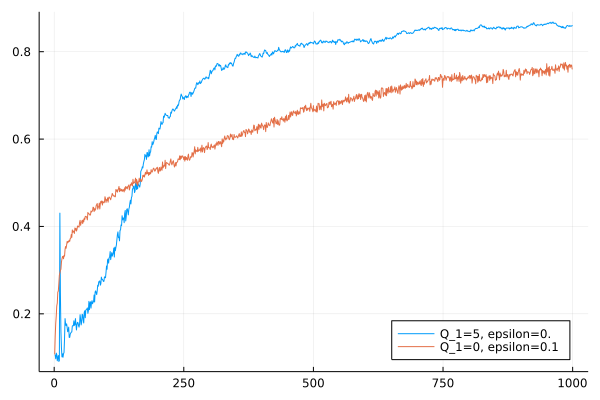

In [14]:
# now compare the effect of setting init value
p_2_3 = plot(legend=:bottomright)

v1 = mean(
	bandit_testbed(
		;explorer=EpsilonGreedyExplorer(0.),
		init=5., 
		opt=Descent(0.1)
	)[1]
	for _ in 1:2000
)
plot!(p_2_3, v1, label="Q_1=5, epsilon=0.")

v2 = mean(
	bandit_testbed(
		;explorer=EpsilonGreedyExplorer(0.1),
		init=0., 
		opt=Descent(0.1)
	)[1]
	for _ in 1:2000
)
plot!(p_2_3, v2, label="Q_1=0, epsilon=0.1")
p_2_3


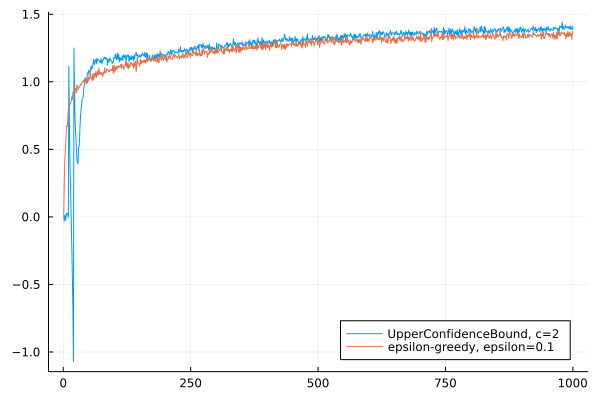

In [15]:
p_2_4 = plot(legend=:bottomright)
plot!(p_2_4, mean(bandit_testbed(;explorer=UCBExplorer(10), opt=Descent(0.1))[2] for _ in 1:5000), label="UpperConfidenceBound, c=2")
plot!(p_2_4, mean(bandit_testbed(;explorer=EpsilonGreedyExplorer(0.1), opt=Descent(0.1))[2] for _ in 1:5000), label="epsilon-greedy, epsilon=0.1")

p_2_4

In [16]:
function gb_bandit_testbed(
	;baseline=0.,
	explorer=WeightedExplorer(is_normalized=true),
	true_reward=0.0,
	init=0.,
	opt=InvDecay(1.0)
)
    env = MultiArmBanditsEnv(;true_reward=true_reward)
	agent = Agent(
	   policy=QBasedPolicy(
		   learner = GradientBanditLearner(
			   approximator = TabularQApproximator(
				   n_state=length(state_space(env)),
				   n_action=length(action_space(env)),
				   init=init,
				   opt = opt
			   ),
			   baseline=baseline
		   ),
		   explorer = explorer
	   ),
	   trajectory=VectorSARTTrajectory()
	)

	h1 = CollectBestActions(;best_action=findmax(env.true_values)[2])
	h2 = TotalRewardPerEpisode(;is_display_on_exit=false)
	run(agent, env, StopAfterStep(1000), ComposedHook(h1, h2))
    h1.isbest, h2.rewards
end

gb_bandit_testbed (generic function with 1 method)